# Time of Emergence of the Global Mean

This version differs from the previous version as it is constucted from draft_03_v2 which uses version that have been shifted to functions and standardised.

In [306]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)

import plotting_functions
import signal_to_noise as sn
import stats

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [307]:
import time_of_emrgence_calc as toe

In [308]:
# from dask.distributed import Client
# client = Client()
# client

In [309]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)

# Opening Best

In [310]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [311]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds = best_ds.rename({'latitude':'lat', 'longitude': 'lon'})
best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()

In [312]:
best_ds_smean = best_ds.clima.space_mean()

In [313]:
# Only 43MB - load into memory
best_ds_smean = best_ds_smean.compute()

In [314]:
best_ds_smean

<xarray.DataArray 'temperature' (time: 175)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... 1.025 0.8704 0.9127 1.204 1.273
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

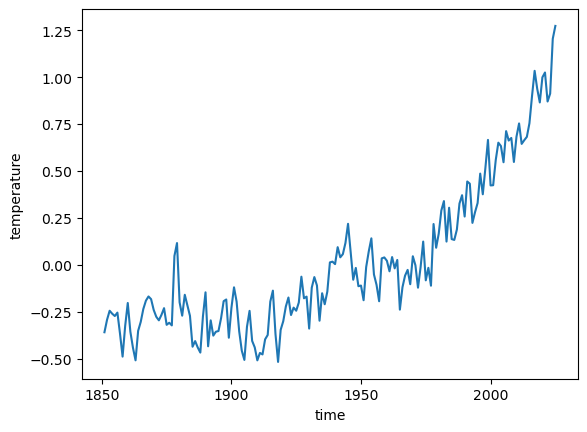

In [315]:
best_ds_smean.plot()

In [316]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds_smean.where(best_ds_smean.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... -0.2842 -0.193 -0.1842 -0.3879 -0.2289
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [317]:
base_period_ds_average = base_period_ds.mean(dim='time')
base_period_ds_average

<xarray.DataArray 'temperature' ()>
-0.2854

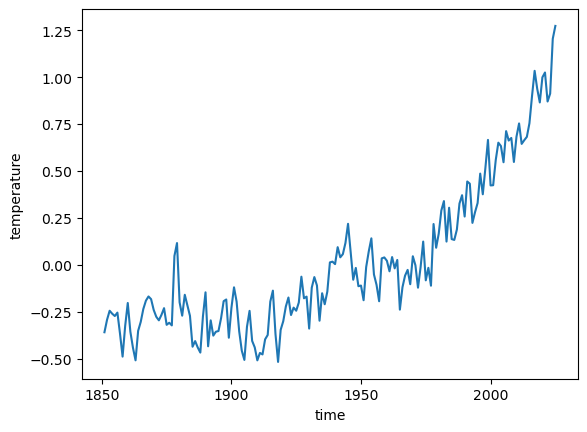

In [318]:
best_ds_smean.plot()

# Calculations

In [319]:
window = 20

## Signal-to-Noise

In [320]:
# As these are anomalies, the signal is just going to be the
ds_best_smooth = stats.trend_fit(best_ds_smean, 'LOWESS', lowess_window=40)#method='POLYNOMIAL', order=4)#

In [321]:
noise_ds = base_period_ds.std(dim='time').to_numpy()
noise_ds

array(0.11661059)

In [337]:
# I know that the temperature is already an anomly, but it cleary wasn't in 
# reference to my base period. This should just translate the data updwardss,
# increasing the signal, so that the baser period is now centered on zero.

ds_best_smooth_signal = ds_best_smooth - base_period_ds_average

In [338]:
ds_best_sn = ds_best_smooth_signal/noise_ds
ds_best_sn

<xarray.DataArray 'temperature' (time: 175)>
-0.3279 -0.3073 -0.2862 -0.2647 -0.2428 ... 10.81 11.02 11.23 11.43 11.64
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

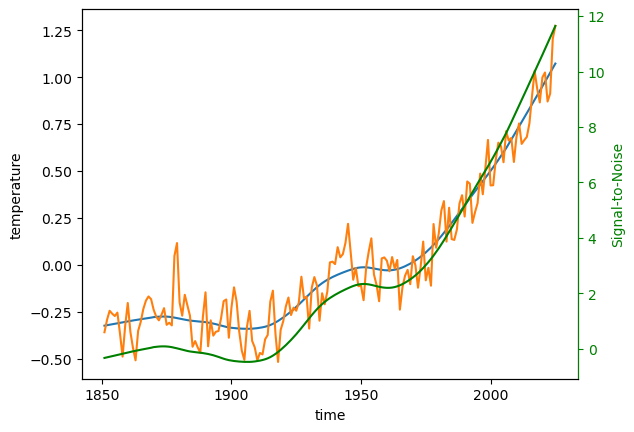

In [339]:
fig, ax = plt.subplots()
ax_twinx = ax.twinx()
ds_best_poly.plot(ax=ax)
best_ds_smean.plot(ax=ax)
ds_best_sn.plot(ax=ax_twinx, color='green')

ax_twinx.set_ylabel('Signal-to-Noise', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

## KS-test

In [340]:
%%time
ks_ds = toe.apply_kstest_along_array(best_ds_smean, window)

CPU times: user 46.2 ms, sys: 70 µs, total: 46.3 ms
Wall time: 44.2 ms


In [341]:
ks_ds_2 = toe.kstest_with_ufunc(best_ds_smean, window, base_period_ds)

In [342]:
ks_ds_2

<xarray.DataArray 'temperature' (time: 156)>
0.9999 0.9999 0.9999 0.9999 0.9999 ... 1.235e-17 1.235e-17 1.235e-17 1.235e-17
Coordinates:
  * time     (time) object 1869-12-31 00:00:00 ... 2024-12-31 00:00:00

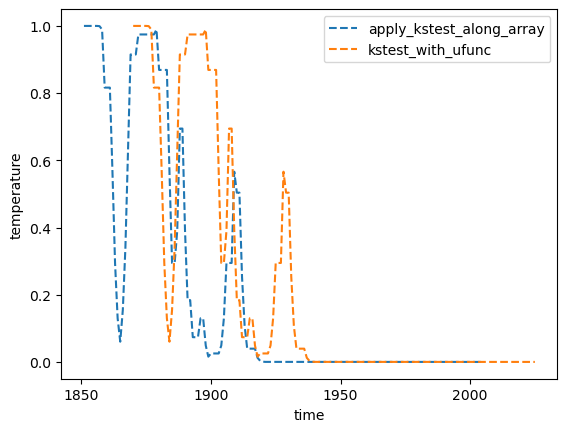

In [343]:
ks_ds.plot(label='apply_kstest_along_array', linestyle='--')
ks_ds_2.plot(label='kstest_with_ufunc', linestyle='--')
plt.legend()

# Getting ToE

In [344]:
sn_toe_val = toe.get_permanent_exceedance(ds_best_sn, threshold=2, comparison_func=np.greater).values

In [345]:
ks_toe_val = toe.get_permanent_exceedance(ks_ds_2, threshold=0.01, comparison_func=np.less).values

In [346]:
exceedance_dict = {
    'ks_test': int(ks_toe_val),
    'signal_to_noise': int(sn_toe_val)
}
exceedance_dict

{'ks_test': 1937, 'signal_to_noise': 1940}

In [347]:
exceedance_dict_w_plot_coords={
    'ks_test':
        {'year': ks_toe_val,
         'year_datetime': ks_ds_2.sel(time=ks_ds_2.time.dt.year==int(ks_toe_val)).time.values[0],
         'val': ks_ds_2.sel(time=ks_ds_2.time.dt.year==int(ks_toe_val)).values[0]
        },
    'sn':
        {'year': sn_toe_val,
         'year_datetime': ds_best_sn.sel(time=ds_best_sn.time.dt.year==int(sn_toe_val)).time.values[0],
         'val': ds_best_sn.sel(time=ds_best_sn.time.dt.year==int(sn_toe_val)).values[0]
        }}

In [348]:
exceedance_dict_w_plot_coords

{'ks_test': {'year': array(1937.),
  'year_datetime': cftime.DatetimeGregorian(1937, 12, 31, 0, 0, 0, 0, has_year_zero=False),
  'val': 0.0031886855178668632},
 'sn': {'year': array(1940.),
  'year_datetime': cftime.DatetimeGregorian(1940, 12, 31, 0, 0, 0, 0, has_year_zero=False),
  'val': 2.0012973984960367}}

# Plotting

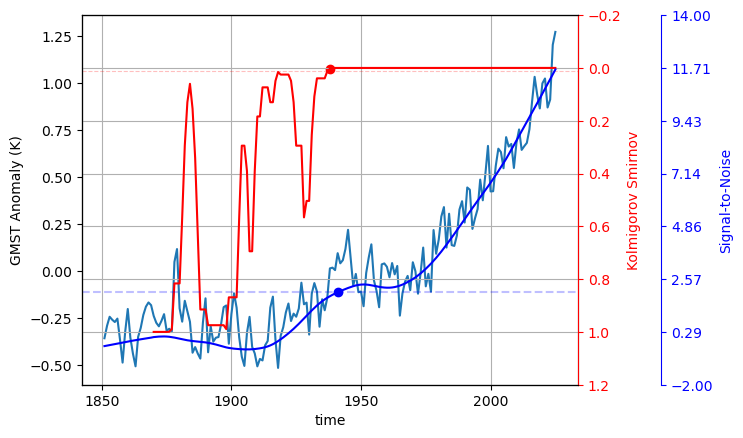

In [349]:
fig, ax_base = plt.subplots()
ax1 = ax_base.twinx() # KS test
ax2 = ax_base.twinx() # SN

ax1.plot(ks_ds_2.time.values, np.abs(ks_ds_2.to_numpy()-1), c='red')
ds_best_sn.plot(ax=ax2, c='blue')

color_cycle = ['red', 'blue']

for ax, color in zip([ax1, ax2],color_cycle):
    ax.spines['right'].set_color(color)
    ax.tick_params(axis='y', color=color, labelcolor=color)


ax1.axhline(0.99, linestyle='--', color='red', alpha=0.25, linewidth=0.8)
ax2.axhline(2, linestyle='--', color='blue', alpha=0.25, linewidth=1.5)


ax2.scatter(exceedance_dict_w_plot_coords['sn']['year_datetime'], exceedance_dict_w_plot_coords['sn']['val'],
            color='blue')
ax1.scatter(exceedance_dict_w_plot_coords['ks_test']['year_datetime'], 
            np.abs(exceedance_dict_w_plot_coords['ks_test']['val']-1),
           color='red')


ax1.set_ylim(-0.1, 1.1)

plotting_functions.match_ticks(ax1, ax2)
ax1.set_yticklabels([label.get_text() for label in ax1.get_yticklabels()][::-1])

ax1.set_ylabel('Kolmigorov Smirnov', color='red')
ax2.set_ylabel('Signal-to-Noise', color='blue')

ax2.spines['right'].set_position(('outward', 60))

best_ds_smean.plot(ax=ax_base)
ax_base.set_ylabel('GMST Anomaly (K)')

ax1.grid(True)
ax_base.grid(True, axis='x')

In [350]:
central_year  = 1883
period_of_interest_ds = best_ds_smean.sel(time=best_ds_smean.time.dt.year.isin(np.arange(central_year-10, central_year+11)))

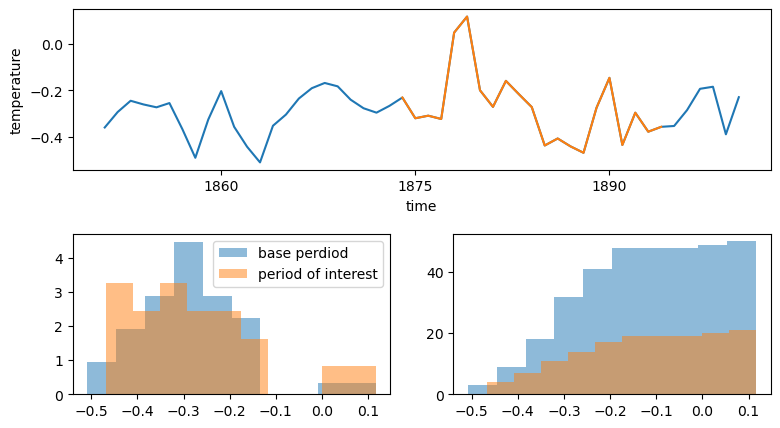

In [351]:
fig  = plt.figure(figsize=(9, 5))
gs = gridspec.GridSpec(2, 2, hspace=0.4)
ax_top = fig.add_subplot(gs[0, :])
axes_bottom = [fig.add_subplot(gs[1, i]) for i in [0, 1]]

base_period_ds.plot(ax=ax_top)
period_of_interest_ds.plot(ax=ax_top)
axes_bottom[0].hist(base_period_ds.values, density=True, alpha=0.5, label='base perdiod');
axes_bottom[0].hist(period_of_interest_ds.values, density=True, alpha=0.5, label='period of interest');
axes_bottom[0].legend(ncol=1)

axes_bottom[1].hist(base_period_ds.values, cumulative=True, alpha=0.5);
axes_bottom[1].hist(period_of_interest_ds.values, cumulative=True, alpha=0.5);